In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('../../../data/kc_house_data_update1.csv')

In [3]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,datefloat,renovated,bath_per_bed,skinniness,dist
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0.0,...,98178,47.5112,-122.257,1340,5650,16356.0,0,0.333333,1180.0,0.154164
1,6414100192,12/09/2014,538000.0,3,2.25,2570,7242,2.0,0,0.0,...,98125,47.7210,-122.319,1690,7639,16413.0,1,0.750000,1285.0,0.161642
2,5631500400,02/25/2015,180000.0,2,1.00,770,10000,1.0,0,0.0,...,98028,47.7379,-122.233,2720,8062,16491.0,0,0.500000,770.0,0.109873
3,2487200875,12/09/2014,604000.0,4,3.00,1960,5000,1.0,0,0.0,...,98136,47.5208,-122.393,1360,5000,16413.0,0,0.750000,1960.0,0.247977
4,1954400510,02/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0.0,...,98074,47.6168,-122.045,1800,7503,16484.0,0,0.666667,1680.0,0.134928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,05/21/2014,360000.0,3,2.50,1530,1131,3.0,0,0.0,...,98103,47.6993,-122.346,1530,1509,16211.0,0,0.833333,510.0,0.177767
21593,6600060120,02/23/2015,400000.0,4,2.50,2310,5813,2.0,0,0.0,...,98146,47.5107,-122.362,1830,7200,16489.0,0,0.625000,1155.0,0.227279
21594,1523300141,06/23/2014,402101.0,2,0.75,1020,1350,2.0,0,0.0,...,98144,47.5944,-122.299,1020,2007,16244.0,0,0.375000,510.0,0.131089
21595,291310100,01/16/2015,400000.0,3,2.50,1600,2388,2.0,0,0.0,...,98027,47.5345,-122.069,1410,1287,16451.0,0,0.833333,800.0,0.153444


In [4]:
data['act_price'] = data['price']
data['price'] = data['price'].map(np.log)

In [5]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
datefloat        0
renovated        0
bath_per_bed     0
skinniness       0
dist             0
act_price        0
dtype: int64

In [6]:
def relevants(data):
    rel = []
    for col in data.columns:
        if data[col].dtype != object:
            rel.append(col)
    return rel

def graphs(data):
    relevant = relevants(data.drop('price', axis = 1))
    rowsplot = int(len(relevant)/3 + 1)

    fig, axes = plt.subplots(nrows = rowsplot, ncols = 3, figsize=(20, 500))

    for col, ax in zip(relevant, axes.flatten()):
        sns.scatterplot(data = data, x = col, y = 'price', ax = ax)
        ax.set_title(col, fontsize = 20)
        
def make_corrs(data, display = False):
    corrs = data.corr().stack().reset_index()
    corrs = corrs.loc[corrs['level_0'] != corrs['level_1']]
    corrs['pair'] = corrs['level_0'] + ' '+ corrs['level_1']
    corrs['pair'] = corrs['pair'].map(lambda x: ', '.join(sorted(x.split(' '))))
    corrs.drop_duplicates(subset = 'pair', inplace = True)
    corrs.drop(['level_1','level_0'], axis = 1, inplace = True)
    corrs.set_index('pair', inplace = True)
    corrs.columns = pd.Series('correlation')
    corrs = abs(corrs).sort_values('correlation', ascending = False)
    if display:
        display(corrs)
    return corrs

def make_high_corrs(data, display = False):
    corrs = make_corrs(data)
    high_corrs = corrs.loc[corrs['correlation']>= 0.75]
    if display:
        display(high_corrs)
    return high_corrs

def make_corrs_with_price(data, display = False):
    corrs = make_corrs(data)
    corrs_with_price = corrs.loc[corrs.index.str.contains('price')]
    if display:
        display(corrs_with_price)
    return corrs_with_price

def check_homoscedastic(data, display = False):
    results = []
    for col in data.drop('price', axis = 1).columns:
        lower = data[col].quantile(0.45)
        upper = data[col].quantile(0.55)
        mids = data.loc[(data[col] >= lower)&(data[col] <= upper)].index

        index = [x for x in data.index if x not in mids]
        formula = f'price~{col}'
        model = smf.ols(formula = formula, data = data).fit()

        results.append((col, sms.het_goldfeldquandt(model.resid.iloc[index], model.model.exog[index])[1]))

    heteroscedastic = [(col, p) for col, p in results if p < 0.05]
    if display:
        print(heteroscedastic)
    
    return heteroscedastic, results

def corr(x, y):
    xbar = x.mean()
    ybar = y.mean()
    return sum((x-xbar)*(y-ybar))/np.sqrt(sum((x-xbar)**2)*sum((y-ybar)**2))



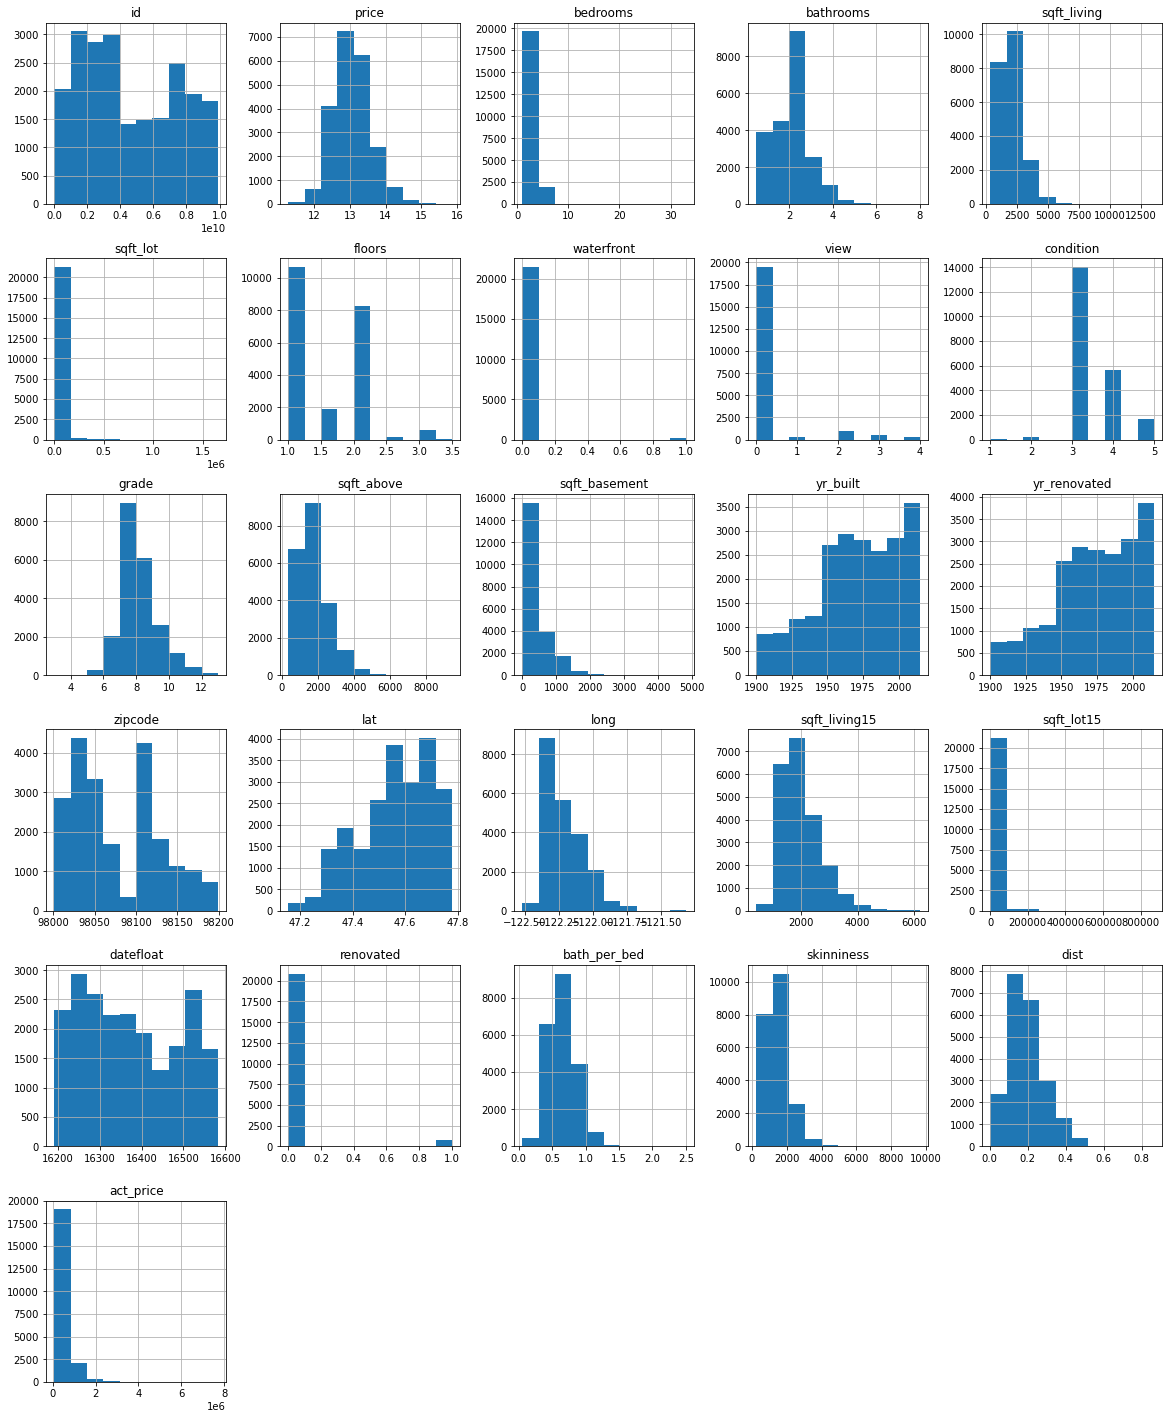

In [7]:
data.hist(figsize = (20,25));

In [8]:
data = data.loc[data['bedrooms'] < 15]

In [9]:
data = data.loc[data['sqft_living'] < 13000]

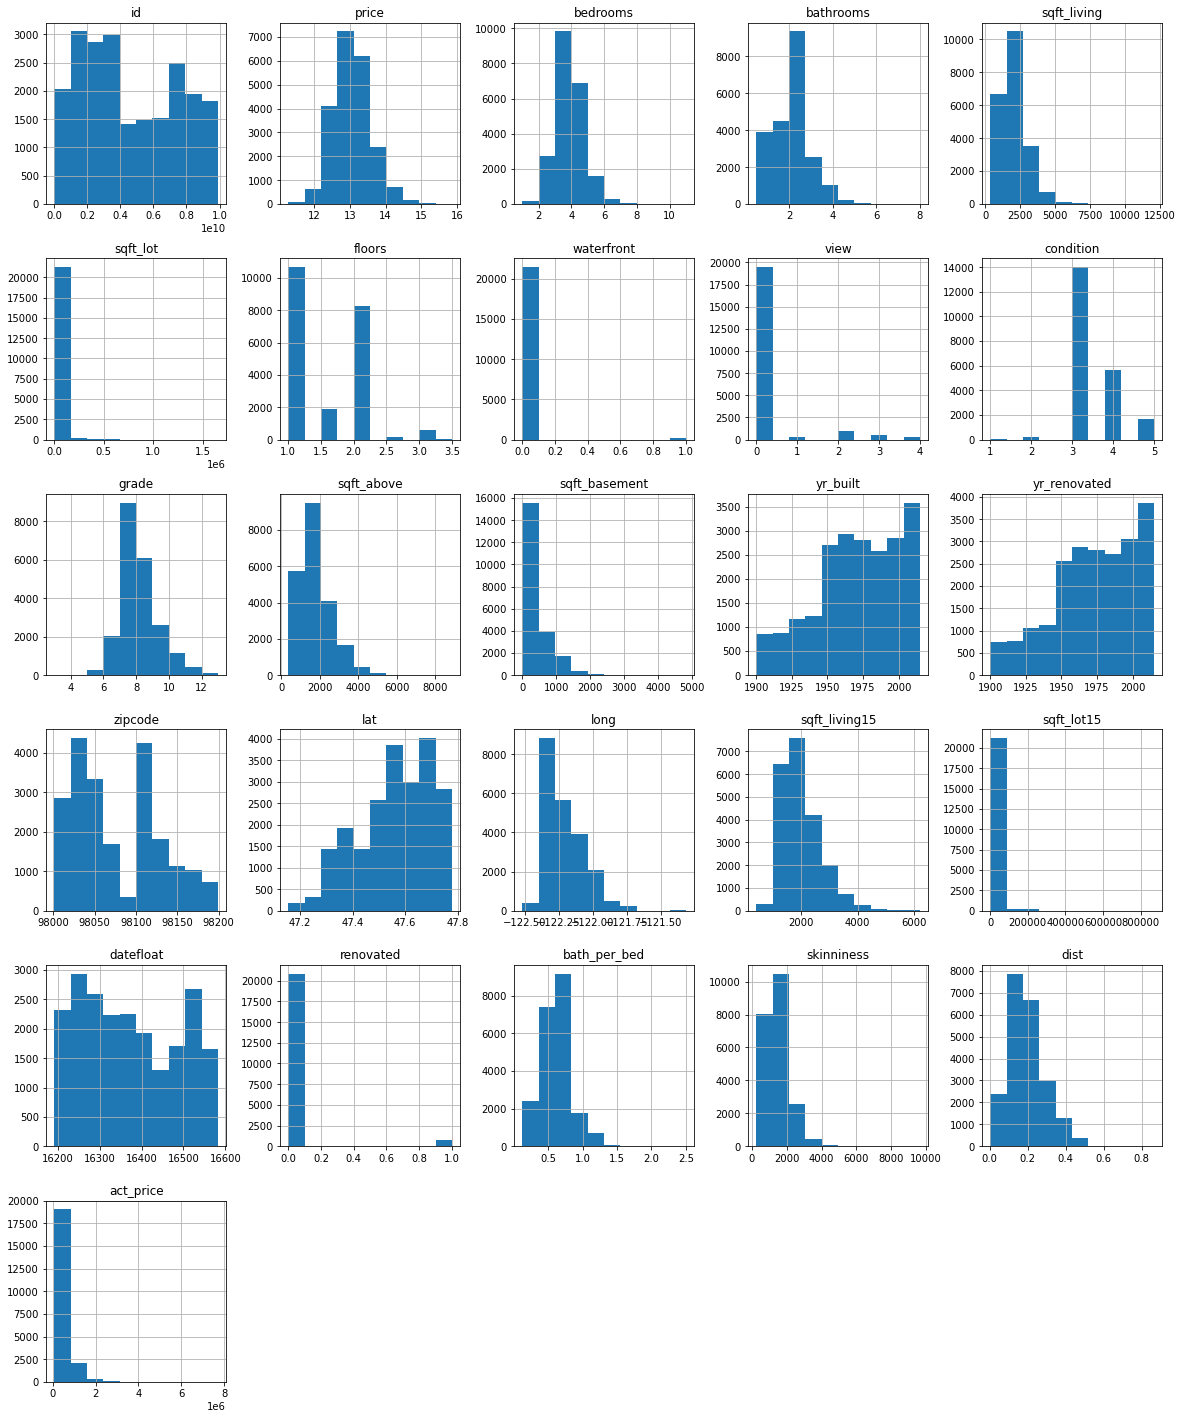

In [10]:
data.hist(figsize = (20,25));

In [11]:
make_corrs_with_price(data)

,correlation
pair,
"act_price, price",0.891735
"grade, price",0.703601
"act_price, sqft_living",0.702092
"price, sqft_living",0.696124
"act_price, grade",0.667711
"price, sqft_living15",0.619168
"act_price, sqft_above",0.604875
"price, sqft_above",0.601642
"act_price, sqft_living15",0.584890


In [12]:
make_high_corrs(data)

,correlation
pair,
"yr_built, yr_renovated",0.927294
"act_price, price",0.891735
"sqft_above, sqft_living",0.876007
"grade, sqft_living",0.763638
"sqft_living, sqft_living15",0.757025
"grade, sqft_above",0.756216
"bathrooms, sqft_living",0.755081


In [13]:
data.shape

(21595, 27)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

In [18]:
poly = PolynomialFeatures(2)
data_cop = data.drop(['price','date','zipcode','datefloat','act_price'], axis = 1)
poly.fit(data_cop)
X = pd.DataFrame(poly.transform(data_cop), columns = poly.get_feature_names(data_cop.columns), index = data_cop.index)
y = data['price']
linreg = LinearRegression()

In [19]:
def five_fold(X, y):
    folds = KFold(n_splits = 5, shuffle = True)
    trains = []
    tests = []
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        linreg.fit(X_train, y_train)
        trains.append(linreg.score(X_train, y_train))
        tests.append(linreg.score(X_test, y_test))

    return sum(trains)/5, sum(tests)/5
    
five_fold(X, y)

(0.7246476138592208, 0.7196677734499154)